In [ ]:
!git clone https://github.com/QuananhNguyen-04/TimeSeriesStock.git

fatal: destination path 'TimeSeriesStock' already exists and is not an empty directory.


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
!pip install vnstock3
from vnstock3 import Vnstock
from tqdm import tqdm


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.0/93.0 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.1/201.1 kB 16.7 MB/s eta 0:00:00

    Khi tiếp tục sử dụng Vnstock3, bạn xác nhận rằng bạn đã đọc, hiểu và đồng ý với Chính sách quyền riêng tư và Điều khoản, điều kiện về giấy phép sử dụng Vnstock3.

    Chi tiết:

    - Giấy phép sử dụng phần mềm: https://vnstocks.com/docs/tai-lieu/giay-phep-su-dung
    - Chính sách quyền riêng tư: https://vnstocks.com/docs/tai-lieu/chinh-sach-quyen-rieng-tu
    


In [ ]:
torch.manual_seed(25)

In [ ]:
# df=pd.read_csv('/content/TimeSeriesStock/data/BID.csv')
# print(df.info())
# df

# # Set the '<DTYYYYMMDD>' column as the index
# df = df.set_index('<DTYYYYMMDD>')
# # Delete the '<Ticker>' column
# del df['<Ticker>']
# del df['<Volume>']
# df

 use vnstock uncomment below

In [ ]:
stock = Vnstock().stock(symbol='BID', source='VCI')
df = stock.quote.history(start='2014-01-01', end='2024-06-21', interval='1D')
datatime = pd.to_datetime(df["time"])
df["year"] = datatime.dt.year
df["month"] = datatime.dt.month
df["day"] = datatime.dt.day
df = df.set_index('time')
df = df.drop(['year', 'month', 'day', 'volume'], axis=1)
df

2024-12-08 15:23:17 - vnstock3.common.data.data_explorer - WARNING - Thông tin niêm yết & giao dịch sẽ được truy xuất từ TCBS


,open,high,low,close
time,,,,
2014-01-24,9.96,10.22,9.70,9.85
2014-01-27,9.80,9.85,9.49,9.65
2014-02-06,9.54,9.59,9.23,9.23
2014-02-07,9.12,9.17,8.65,8.70
2014-02-10,8.65,9.02,8.49,8.91
...,...,...,...,...
2024-06-17,47.50,47.50,46.50,46.50
2024-06-18,46.70,47.05,46.50,46.50
2024-06-19,46.80,46.80,45.85,46.10


In [ ]:
data = {}
company = "BID"
data[company] = torch.tensor(df.values)


In [ ]:
class MyDataset(Dataset):
    def __init__(self, data: torch.Tensor, seq_len):
        print(data.shape)
        self.scaler = 24
        self.X = data[:, :] / self.scaler # All sequences, except the last element, all features
        self.Y = data[:, 3] / self.scaler  # All sequences, only the last element, Close feature
        self.seq_len = seq_len
        self.lagging = 0

    def __len__(self):
        return len(self.X) - self.seq_len - self.lagging

    def __getitem__(self, idx):
        if idx < 0:
            idx = self.__len__() + idx

        return {
            'seq': self.X[idx: idx + self.seq_len],
            'label': self.Y[idx + self.seq_len + self.lagging]
        }

In [ ]:
test_ratio = 0.9
split_index = int(len(data[company]) * test_ratio)

train_d, test_d = data[company][:split_index], data[company][split_index:]

In [ ]:
# Create datasets
seq_len = 50
def create_dataset(seq_len):
  train_dataset = MyDataset(train_d, seq_len)
  test_dataset = MyDataset(test_d, seq_len)

  # Create DataLoaders
  batch_size = 64  # Adjust as needed
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
  for batch in train_loader:
      seq = batch["seq"]
      label = batch["label"]

      print("Sequence shape:", seq.shape)
      print("Label shape:", label.shape)
      break
  return train_dataset, test_dataset, train_loader, test_loader

In [ ]:
# prompt: Using dataframe df: scale the data  with min max scaler

# from sklearn.preprocessing import MinMaxScaler

# # Create a MinMaxScaler object
# scaler = MinMaxScaler()

# # Select numerical columns to scale (excluding the date column)
# numerical_cols = ['open','high','low','close','volume']

# # Fit the scaler to the data and transform the numerical columns
# df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
# df

# Model RNN

In [ ]:
class Model(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=2):
        super(Model, self).__init__()
        self.rnn = nn.RNN(
            input_dim,
            hidden_dim,
            num_layers,
            dropout=0,
            batch_first=True,
            nonlinearity='tanh',
        )
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        # self.fci = nn.Linear(seq_len * hidden_dim, 8)
        self.fc = nn.Linear(hidden_dim, 1)
        # self.relu = nn.ReLU()

        for name, param in self.rnn.named_parameters():
            if 'weight_ih' in name:
                # Input-to-hidden weights: Xavier Uniform Initialization
                nn.init.xavier_uniform_(param.data)
            elif 'weight_hh' in name:
                # Hidden-to-hidden weights: Orthogonal Initialization
                nn.init.orthogonal_(param.data)
            elif 'bias' in name:
                nn.init.constant_(param.data, 0)
    def forward(self, x):
        if self.rnn.batch_first is True:
            h0 = torch.zeros(
                self.num_layers, x.size(0), self.hidden_dim
            ).to(x.device)
        out, _ = self.rnn(x, h0)

        out = self.fc(out)
        out = out.squeeze(-1)

        return out

In [ ]:
def calculate_mape(y_true, y_pred):
    """
    Calculates the Mean Absolute Percentage Error (MAPE).

    Args:
        y_true: The actual values.
        y_pred: The predicted values.

    Returns:
        The MAPE value.
    """

    # Convert to NumPy arrays if necessary
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    # print (f"cal acc with true = {y_true} and pred = {y_pred}")
    # Avoid division by zero
    mask = y_true != 0

    # Calculate MAPE
    mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

    return mape

In [ ]:
def train_one_epoch(RNN):
    RNN.train(True)

    running_loss = 0
    running_accuracy = 0.0
    for batch_idx, batch in enumerate(train_loader):
        inputs = batch['seq'].to(device).type(torch.float32)  # Move to device
        labels = batch['label'].to(device).type(torch.float32)   # Move to device


        optimizer.zero_grad()
        outputs = RNN(inputs)

        outputs = outputs[:,-1]
        # outputs = outputs.reshape(-1, 1)
        # if(batch_idx == 0):
        #     print(f"inputs : {inputs}")
        #     print(f"outputs  {outputs}")
        #     print(f"labels : {labels}")
        #     y_true = np.array(labels.cpu().detach().numpy())
        #     y_pred = np.array(outputs.cpu().detach().numpy())
        #     mask = y_true != 0
        #     mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
        #     print(f"mape cal with  : {np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask]))}")

        # correct = torch.sum(torch.argmax(outputs,dim=1) == labels).item()
        acc = calculate_mape(labels.cpu().detach().numpy(), outputs.cpu().detach().numpy())
        running_accuracy += acc
        # print(f"outputs shape: {outputs.shape}")
        # print(f"labels shape: {labels.shape}")
        # Ensure loss calculation is done with Float tensors
        # print(f"outputs shape: {outputs.shape}")
        # print(f"labels shape: {labels.shape}")
        rmse_loss = torch.sqrt(criterion(outputs, labels.type(torch.float32)))
        running_loss += rmse_loss.item()
        # print(f"Batch {batch_idx + 1} Loss: {loss.item():.4f}")
        # print(f"Batch {batch_idx + 1} Accuracy: {acc:.4f}")
        rmse_loss.backward()
        # for name, param in RNN.named_parameters():
        #     if param.requires_grad and param.grad is not None:
        #         print(f"Parameter: {name}")
        #         print(f"Grad shape: {param.grad.shape}")
        #         print(f" Gradient: {param.grad}")
        # print("-" * 30)
        optimizer.step()
        if batch_idx % 500 == 499:  # print every 500 batches
            avg_loss_across_batches = running_loss / 500
            avg_acc_across_batches = (running_accuracy / 500) * 100
            print('Batch {0}, Loss: {1:.3f}, Accuracy: {2:.1f}%'.format(batch_idx+1,
                                                            avg_loss_across_batches,
                                                            avg_acc_across_batches))

            running_loss = 0.0
            running_accuracy = 0.0
print()

In [ ]:

def validate_one_epoch(RNN):
        RNN.eval()
        running_loss = 0.0
        running_acc = 0.0
        # Initialize variables for evaluation metrics

        total_samples = 0

        for batch_idx, batch in enumerate(test_loader):
            inputs = batch['seq'].to(device).type(torch.float32)  # Move to device
            labels = batch['label'].to(device).type(torch.float32)   # Move to device

            with torch.no_grad():
                outputs = RNN(inputs)  # Shape: [batch_size, 1] (assuming single output)

                # Calculate loss
                outputs = outputs[:,-1]
                # outputs = outputs.reshape(-1, 1)
                rmse_loss = torch.sqrt(criterion(outputs, labels))
                # print(f"outputs : {outputs}")
                # print(f"labels : {labels}")
                # print(outputs, labels)
                running_loss += rmse_loss.item()
                #print batch loss
                # print(f"Validation Batch {batch_idx + 1} Loss: {loss.item():.4f}")
                running_acc += calculate_mape(labels.cpu().detach().numpy(), outputs.cpu().detach().numpy()) * len(labels)
                total_samples += len(labels)
                # if batch_idx ==0 : print(f"len label is {len(labels)}")
                # break
        # print(f"total sample is {total_samples}")
        avg_rmse = running_loss / total_samples
        avg_mape = running_acc / total_samples

        # print(' Validate loss  ( RMSE ): {0:.5f}, Accuracy ( MAPE ): {1:.5f}'.format( avg_rmse, avg_mape))
        # print('****************************************')
        # print()
        return avg_rmse, avg_mape

# Training

## Training with sequence_length = 50

In [ ]:
# prompt: from save_test_loss, plot it
def plot_loss(save_test_loss, title):
  save_test_loss = [avg_loss for avg_loss in save_test_loss]
  # Assuming 'save_test_loss' is a list containing the test loss values from each epoch
  plt.plot(save_test_loss)
  plt.xlabel("Epoch")
  plt.ylabel("Test Loss")
  plt.title(f"Test Loss vs. Epoch, {title}")
  plt.grid(True)
  plt.show()

In [ ]:
def plot_mape(mape_loss, title):
  mape_loss = [avg_mape for avg_mape in mape_loss]
  # Assuming 'save_test_loss' is a list containing the test loss values from each epoch
  plt.plot(mape_loss)
  plt.xlabel("Epoch")
  plt.ylabel("MAPE Loss")
  plt.title(f"MAPE Loss vs. Epoch, {title}")
  plt.grid(True)
  plt.show()

In [ ]:
# prompt: use model to predict all dataset and plot it
def simulate(RNN):
  eval_dataset = DataLoader(test_dataset, batch_size=1, shuffle=False)
  RNN.eval()
  with torch.inference_mode():
      predictions = []
      actual_values = []
      for i, batch in enumerate(eval_dataset):
          # if i < 1500:
          #     continue
          input = batch['seq'].to(device).type(torch.float32)
          truth = batch['label'].to(device).type(torch.float32)
          out = RNN(input)
          # seq = seq.unsqueeze(-1)
          # out = LSTM(seq)
          # print(out.shape)
          # print(truth.shape)
          # reverse_pred = np.repeat(out[0, -5].cpu().numpy(), 5, axis=0).reshape(1, -1)
          # print(reverse_pred)
          # print(scaler.inverse_transform(reverse_pred)[0, -5], y_eval[0, 0])
          # truth_pred = dataset.Scaler.inverse_transform(reverse_pred)[0, -2]
          predictions.append((out[0, -1] * test_dataset.scaler).cpu().numpy())
          actual_values.append((truth[0] * test_dataset.scaler).cpu().numpy())
          # print(out[0, -1], truth[0])
          # print(f"Pred: {truth_pred[-1, -5]}, Actual: {truth[-1, -1]}")

  print(len(predictions))
  print(len(actual_values))


  # Plot the predictions against the actual values
  plt.figure(figsize=(15, 6))
  plt.plot(actual_values, label="Actual Values")
  plt.plot(predictions, label="Predictions")
  plt.xlabel("Time Steps")
  plt.ylabel("Value")
  plt.title("Predictions vs. Actual Values")
  plt.legend()
  plt.show()


In [ ]:
num_epochs = 200
# def training(save_test_loss, model):
#   for epoch in range(num_epochs):
#     # print(f'Epoch: {epoch+1}')
#     train_one_epoch(model)
#     avg_rmse = validate_one_epoch(model)
#     save_test_loss.append(avg_rmse)
def training(save_test_loss, mape_loss, model):
  for epoch in tqdm(range(num_epochs), desc="Training Epochs"):
    # print(f'Epoch: {epoch+1}')
    train_one_epoch(model)
    avg_rmse, avg_mape = validate_one_epoch(model)
    mape_loss.append(avg_mape)
    save_test_loss.append(avg_rmse)
  print(min(mape_loss), min(save_test_loss))

In [ ]:
train_dataset, test_dataset, train_loader, test_loader = create_dataset(50)

torch.Size([2335, 4])
torch.Size([260, 4])
Sequence shape: torch.Size([64, 50, 4])
Label shape: torch.Size([64])


In [ ]:
save_test_loss_50 = []
mape_loss_50 = []

In [ ]:
RNN_50 = Model(input_dim=4, hidden_dim=5, num_layers=1)
RNN_50.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(RNN_50.parameters(), lr=0.01)

In [ ]:
training(save_test_loss_50, mape_loss_50, RNN_50)

Training Epochs: 100%|██████████| 200/200 [00:24<00:00,  8.31it/s]

2.9895005233231045 0.0012331783594120116


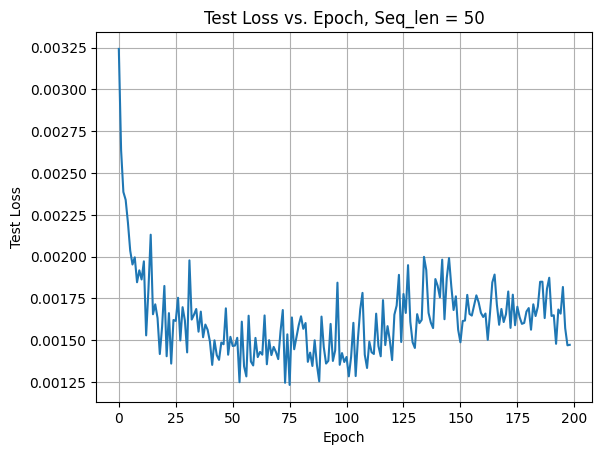

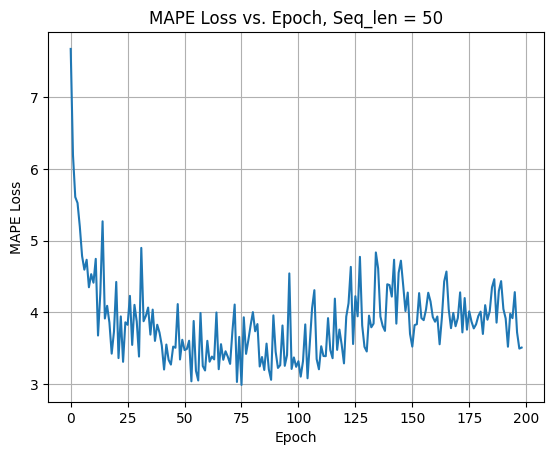

210
210


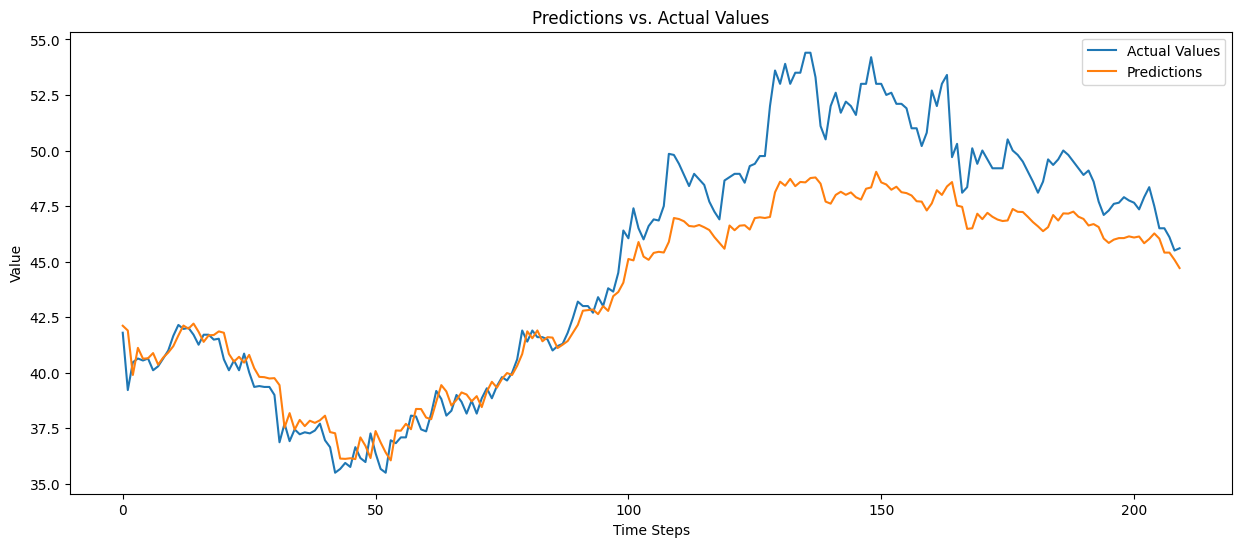

In [ ]:
plot_loss(save_test_loss_50[1:], "Seq_len = 50")
plot_mape(mape_loss_50[1:], "Seq_len = 50")
simulate(RNN_50)

## Training with sequence length = 100

In [ ]:
train_dataset, test_dataset, train_loader, test_loader = create_dataset(100)

torch.Size([2335, 4])
torch.Size([260, 4])
Sequence shape: torch.Size([64, 100, 4])
Label shape: torch.Size([64])


In [ ]:
save_test_loss_100 = []
mape_loss_100 = []

In [ ]:
RNN_100 = Model(4, 5, 1)
RNN_100.to(device)
criterion = nn.MSELoss()            # it should be RMSE , but since i dont see that in pytorch i ll sqrt it later
optimizer = optim.Adam(RNN_100.parameters(), lr=0.01)

In [ ]:
training(save_test_loss_100,mape_loss_100, RNN_100)

Training Epochs: 100%|██████████| 200/200 [01:49<00:00,  1.83it/s]

1.6387305036187172 0.0007316740462556482


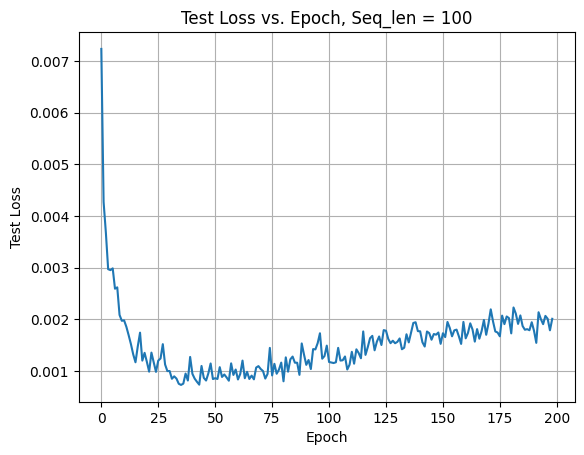

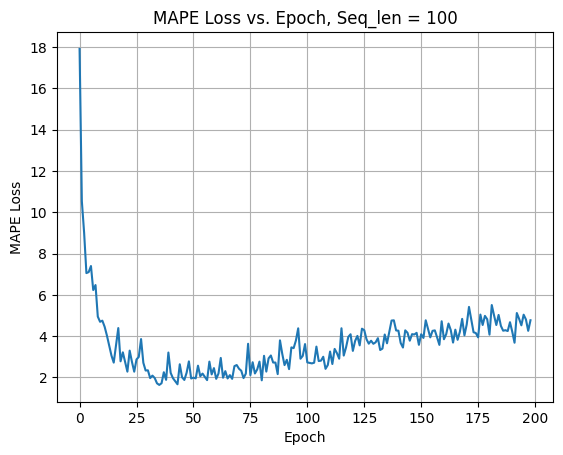

160
160


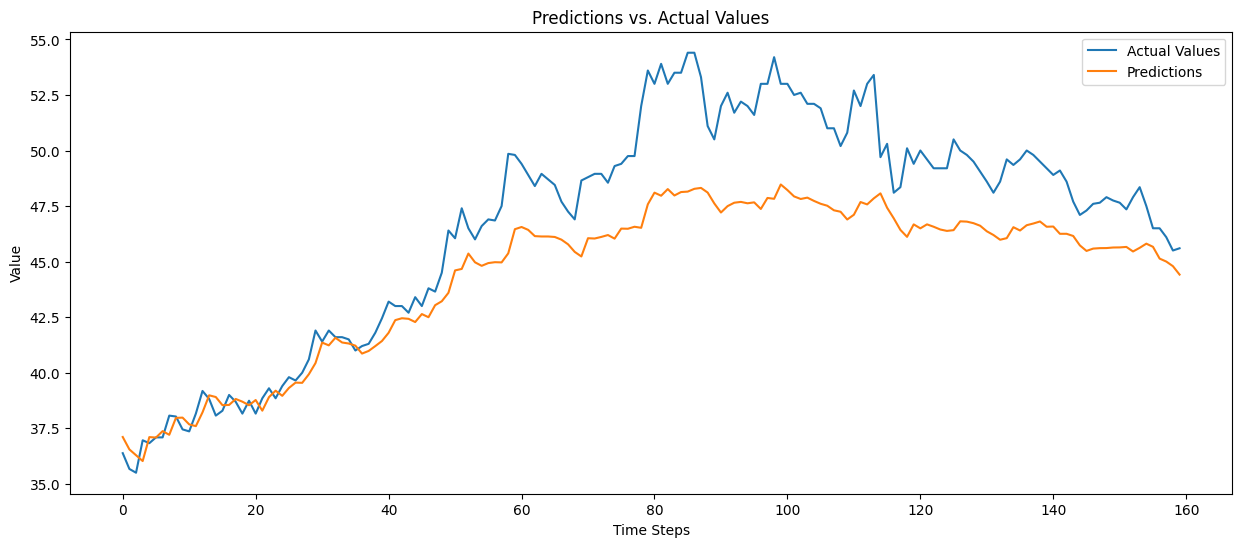

In [ ]:
plot_loss(save_test_loss_100[1:], "Seq_len = 100")
plot_mape(mape_loss_100[1:], "Seq_len = 100")
simulate(RNN_100)

## Training with sequence length = 10

In [ ]:
train_dataset, test_dataset, train_loader, test_loader = create_dataset(10)

torch.Size([2335, 4])
torch.Size([260, 4])
Sequence shape: torch.Size([64, 10, 4])
Label shape: torch.Size([64])


In [ ]:
save_test_loss_10 = []
mape_loss_10 = []

In [ ]:
RNN_10 = Model(4, 5, 1)
RNN_10.to(device)
criterion = nn.MSELoss()            # it should be RMSE , but since i dont see that in pytorch i ll sqrt it later
optimizer = optim.Adam(RNN_10.parameters(), lr=0.01)

In [ ]:
training(save_test_loss_10, mape_loss_10, RNN_10)

Training Epochs: 100%|██████████| 200/200 [00:34<00:00,  5.80it/s]

1.822107794880867 0.0007326558753848076


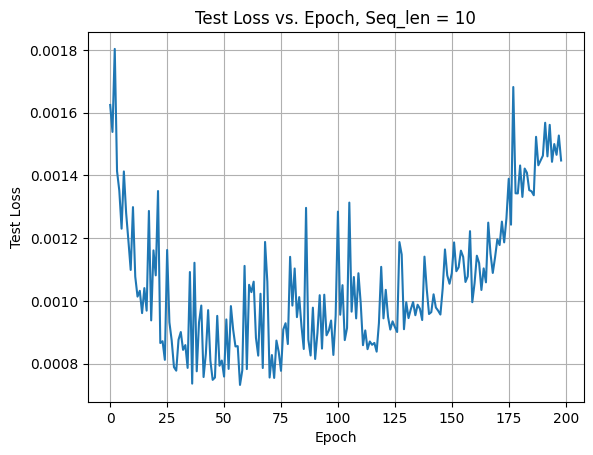

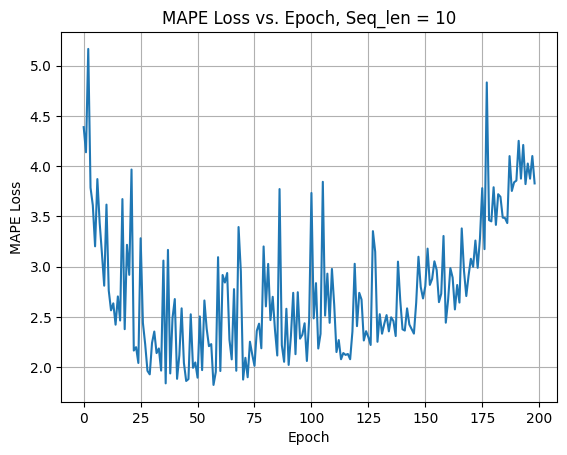

250
250


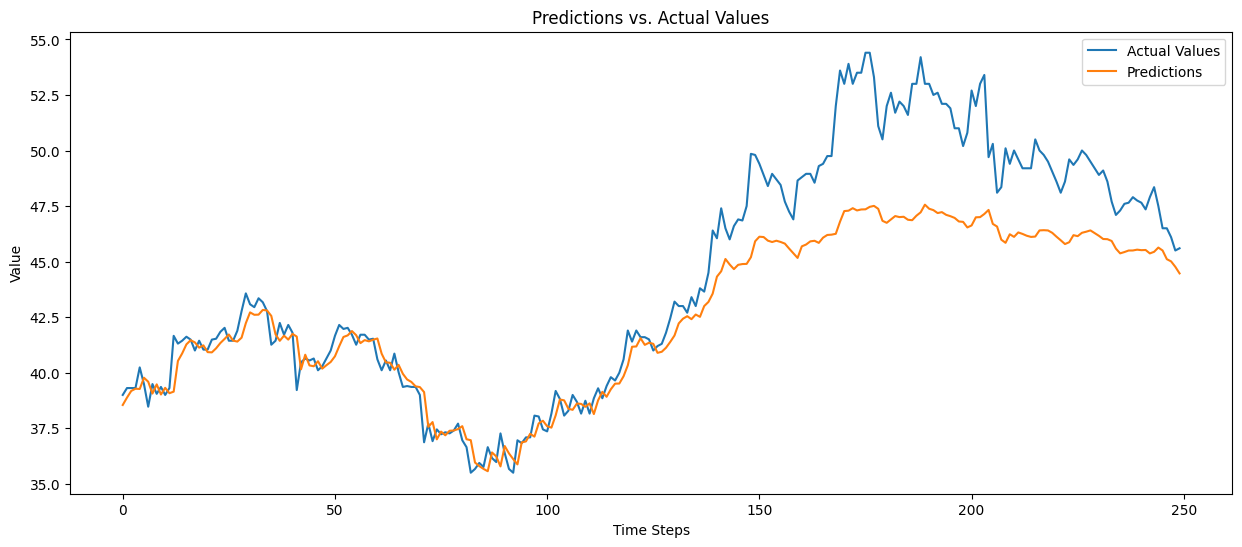

In [ ]:
plot_loss(save_test_loss_10[1:], "Seq_len = 10")
plot_mape(mape_loss_10[1:], "Seq_len = 10")
simulate(RNN_10)

## Training with sequence length = 20

In [ ]:
train_dataset, test_dataset, train_loader, test_loader = create_dataset(20)

torch.Size([2335, 4])
torch.Size([260, 4])
Sequence shape: torch.Size([64, 20, 4])
Label shape: torch.Size([64])


In [ ]:
save_test_loss_20 = []
mape_loss_20 = []

In [ ]:
RNN_20 = Model(4, 5, 1)
RNN_20.to(device)
criterion = nn.MSELoss()            # it should be RMSE , but since i dont see that in pytorch i ll sqrt it later
optimizer = optim.Adam(RNN_20.parameters(), lr=0.01)

In [ ]:
training(save_test_loss_20, mape_loss_20, RNN_20)

Training Epochs: 100%|██████████| 200/200 [00:40<00:00,  4.90it/s]

1.6772698735197384 0.0006889278845240673


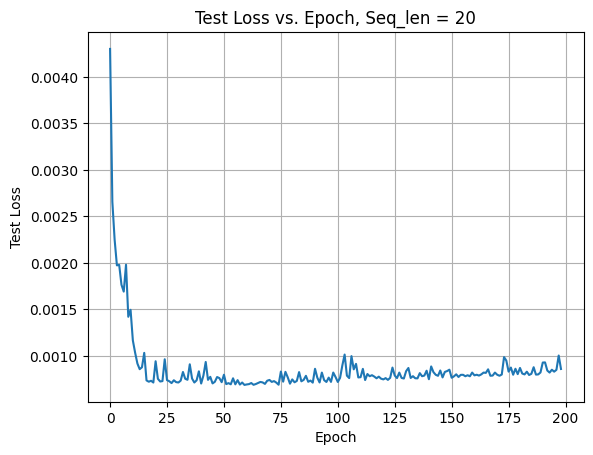

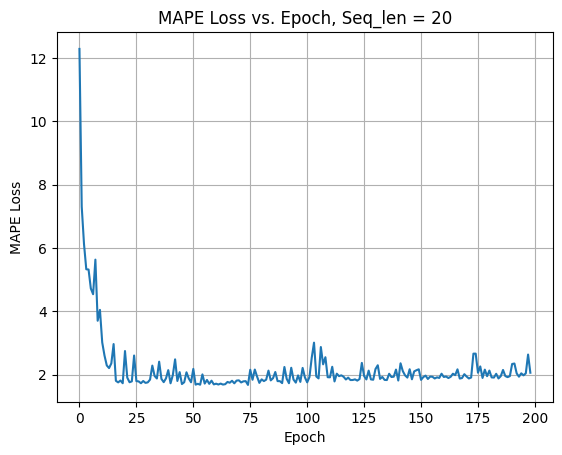

240
240


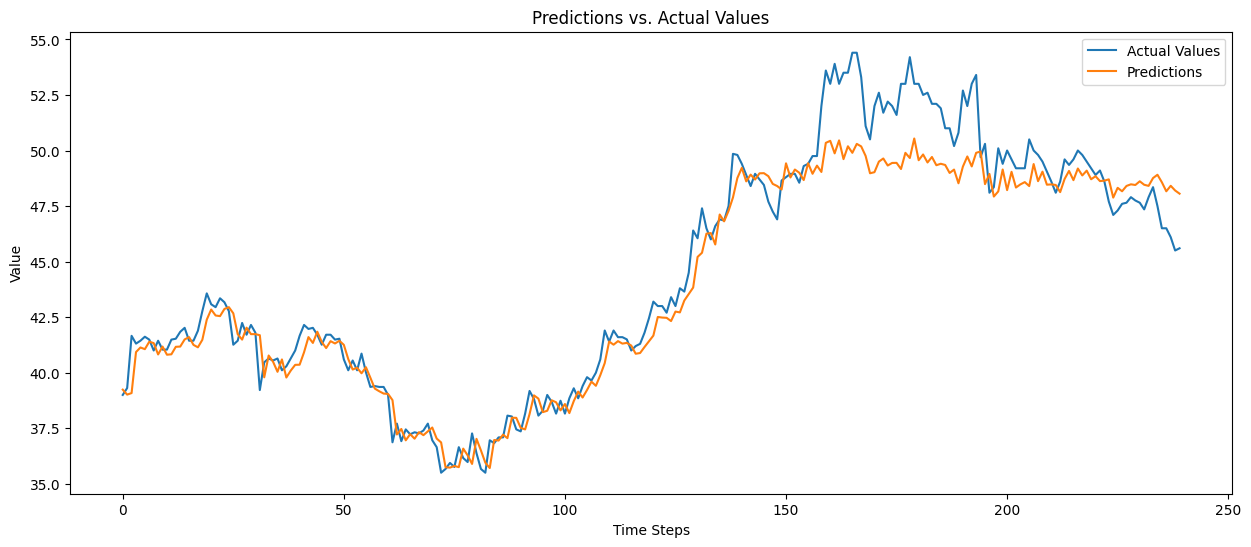

In [ ]:
plot_loss(save_test_loss_20[1:], "Seq_len = 20")
plot_mape(mape_loss_20[1:], "Seq_len = 20")
simulate(RNN_20)

# Debug, view inside


In [ ]:
# prompt: printing every parameters in model
for i, layer in enumerate(RNN.modules()):
       print(f"Layer {i}: {layer}")
for name, param in RNN.named_parameters():
  print(f"Parameter Name: {name}")
  print(f"Parameter Shape: {param.shape}")
  print(f"Parameter Data: {param}")
  print("-" * 30)

Layer 0: Model(
  (rnn): RNN(4, 5, num_layers=2, batch_first=True)
  (fc): Linear(in_features=5, out_features=1, bias=True)
)
Layer 1: RNN(4, 5, num_layers=2, batch_first=True)
Layer 2: Linear(in_features=5, out_features=1, bias=True)
Parameter Name: rnn.weight_ih_l0
Parameter Shape: torch.Size([5, 4])
Parameter Data: Parameter containing:
tensor([[-0.3485, -0.5497, -0.2313, -0.3884],
        [ 0.3012, -0.4742, -0.2688, -0.8573],
        [ 0.9384,  0.6462, -0.4211,  0.9262],
        [-0.3322,  0.5401,  0.2709,  0.7537],
        [ 0.3640,  0.0653, -0.8059, -1.3253]], device='cuda:0',
       requires_grad=True)
------------------------------
Parameter Name: rnn.weight_hh_l0
Parameter Shape: torch.Size([5, 5])
Parameter Data: Parameter containing:
tensor([[ 0.3556, -0.0929,  0.3224,  0.7777, -0.5485],
        [-0.6296, -0.3697,  0.8552,  0.5705, -0.5408],
        [-0.0560,  0.2732,  0.1309,  0.0691, -0.0655],
        [-0.2992,  0.4280, -0.1519,  0.2138,  0.2574],
        [-0.4526, -0.8113